In [26]:
import os
import textstat
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, LabelEncoder

from xgboost import XGBClassifier  #Does not work with sklearn version>=1.6

In [27]:
# Read the data set
train_set = pd.read_csv("../../data/answerList_data.csv")
file_path = "../../data/"
# iterate over all files in the directory and store the content
files = {}
for filename in os.listdir(file_path):
    if filename.startswith("HIT"):
        # file is a java file read the file content and store it in the dictionary
        files[filename.split(".")[0]] = open(file_path + filename, "r").read()

In [28]:
train_set.head(50)

,Answer.ID,FailingMethod,Question.ID,Answer.duration,Answer.confidence,Answer.difficulty,GroundTruth,TP,TN,FN,...,Code.complexity,Worker.ID,Worker.score,Worker.profession,Worker.yearsOfExperience,Worker.age,Worker.gender,Worker.whereLearnedToCode,Worker.country,Worker.programmingLanguage
0,261,HIT01_8,0,90.984,4,2,0,0,1,0,...,1,832cg-7G1i-462:73eI-8E-2g-985,5,Undergraduate_Student,7.0,21,Male,High School,United States,Java; C++; C#
1,262,HIT01_8,0,133.711,5,1,0,0,1,0,...,1,98ce7A-4i-507,4,Undergraduate_Student,10.0,25,Female,High School;University;Web,United States,c#
2,263,HIT01_8,0,77.696,5,2,0,0,1,0,...,1,881AC0I2E-625:135cI3E-7e8-86,5,Professional_Developer,7.0,24,Male,High School;University;Web,United States,C++;Java;PHP
3,264,HIT01_8,0,46.644,1,1,0,0,1,0,...,1,270eG-5c6A3-46:65eI-2i-2I-9-36,5,Professional_Developer,20.0,38,Male,High School;University;Other On the job,USA,C#
4,265,HIT01_8,0,215.416,5,5,0,0,1,0,...,1,844Cg1g5e1-17:255ei-8G8E85-8,3,Undergraduate_Student,5.0,19,Male,High School;University;Web,United States,C++; Java
5,266,HIT01_8,0,126.945,5,1,0,0,1,0,...,1,59gA3i5E2-7-9:249IE-2a8E-92-1,5,Graduate_Student,12.0,40,Male,University;Web,Colombia,C++
6,267,HIT01_8,0,113.620,4,2,0,0,1,0,...,1,656AI5G0i-32-5,4,Undergraduate_Student,4.0,20,Male,University;Web,USA,Java; PHP; HTML
7,268,HIT01_8,0,981.882,4,4,0,0,1,0,...,1,452Ig6c-9G-502:768Ga1I8G-27-2:69eC6i-8G00-4,4,Hobbyist,35.0,59,Male,University;Web;Other self study,USA,Euphoria
8,269,HIT01_8,0,26.997,0,4,0,0,0,0,...,1,40Ge-1c-3I-31-7,4,Professional_Developer,3.0,23,Male,University,India,HTML
9,270,HIT01_8,0,17.746,0,4,0,0,0,0,...,1,1338Ag-4A7i-4-85,3,Graduate_Student,2.0,26,Male,University;Web,USA,java


In [29]:
# shuffle the data set
train_set = train_set.sample(frac=1, random_state=40).reset_index(drop=True)

In [30]:
# use textstat to calculate the Flesch reading ease score for the explanation column keep the original column
train_set["Answer.explanation_length"] = train_set["Answer.explanation"].apply(
    lambda x: len(str(x)) if pd.notnull(x) else None)
train_set["Flesch_reading_ease"] = train_set["Answer.explanation"].apply(
    lambda x: textstat.flesch_reading_ease(x) if pd.notnull(x) else None)

# drop answer.explanation column
train_set = train_set.drop(labels=["Answer.explanation"], axis=1)

In [31]:
# remove unnecessary columns
# and apply the StandardScaler to scale them. Replace the original numerical columns
train_set = train_set.drop(labels=["Answer.ID", "Question.ID", "FP", "FN", "TP", "TN", "Worker.ID"], axis=1)


In [32]:

# use standard scaler for all numerical columns
# Identify numerical columns and use StandardScaler to scale them
numerical_cols = train_set.select_dtypes(include=['float64', 'int64']).columns
# Remove the GroundTruth, Answer.explanation_length and Flesch_reading_ease  columns from the list of numerical columns
numerical_cols = numerical_cols.drop("Answer.explanation_length")
numerical_cols = numerical_cols.drop("Flesch_reading_ease")
scaler = StandardScaler()
numerical_cols = numerical_cols.drop("GroundTruth")
train_set[numerical_cols] = scaler.fit_transform(train_set[numerical_cols])


In [33]:

# Use label encoding to transform the categorical columns into numerical columns and replace the original columns, do not replace multi_cols
multi_cols = ["Worker.whereLearnedToCode", "Worker.programmingLanguage"]
label_encoder = LabelEncoder()
for column in train_set.columns:
    if column not in multi_cols and train_set[column].dtype == "object":
        # for FailingMethod store the original values in another dictionary
        if column == "FailingMethod":
            failing_methods = train_set[column].unique()
            failing_methods_dict = {i: failing_methods[i] for i in range(len(failing_methods))}
        train_set[column] = label_encoder.fit_transform(train_set[column].astype(str))



In [34]:
# Split the multilabel column into a list of labels
multi_cols = ["Worker.whereLearnedToCode", "Worker.programmingLanguage"]
for column in multi_cols:
    # set column to lower case
    train_set[column] = train_set[column].str.lower()
    # split the column by ;
    train_set[column] = train_set[column].apply(lambda x: x.split(";") if pd.notnull(x) else None)
    # remove the spaces from the list
    for i in range(len(train_set[column])):
        if train_set[column][i] is not None:
            train_set[column][i] = [x.strip() for x in train_set[column][i]]

    # replace None with empty list
    train_set[column] = train_set[column].apply(lambda x: [] if x is None else x)
    mlb = MultiLabelBinarizer()

    # Transform the multi-selection column into a one-hot encoded DataFrame
    one_hot_encoded = pd.DataFrame(mlb.fit_transform(train_set[column]),
                                   columns=mlb.classes_,
                                   index=train_set.index)

    # Merge the one-hot encoded columns back with the original DataFrame
    train_set = pd.concat([train_set, one_hot_encoded], axis=1)
    train_set.drop(columns=[column], inplace=True)



IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [35]:
train_set.head(20)

,FailingMethod,Answer.duration,Answer.confidence,Answer.difficulty,GroundTruth,Answer.option,Answer.order,Code.LOC,Code.complexity,Worker.score,...,vb.net,vba,vbs,vbscript,vhdl,visual basic,visual fox pro,visual foxpro,visualbasic,xml
0,2,0.773843,0.980339,-1.581941,0,1,1.318733,-0.453785,0.099595,1.014229,...,0,0,0,0,0,0,0,0,0,0
1,6,-0.029984,0.363142,-0.006108,0,1,0.080621,-0.453785,-0.484396,-1.425594,...,0,0,0,0,0,0,0,0,0,0
2,2,0.067560,-0.254056,0.781809,1,2,0.080621,-0.453785,-0.484396,1.014229,...,0,0,0,0,0,0,0,0,0,0
3,5,2.408056,-1.488450,0.781809,0,2,-1.157491,-0.453785,-0.484396,1.014229,...,0,0,0,0,0,0,0,0,0,0
4,1,-0.464041,0.363142,0.781809,0,2,0.080621,-0.453785,-0.484396,-1.425594,...,0,0,0,0,0,0,0,0,0,0
5,5,-0.331645,-0.254056,-0.006108,0,1,-1.157491,1.062750,0.683587,1.014229,...,0,0,0,0,0,0,0,0,0,0
6,7,-0.378800,0.980339,-1.581941,0,1,-1.157491,-0.453785,-0.484396,-1.425594,...,0,0,0,0,0,0,0,0,0,0
7,0,-0.227987,0.980339,1.569725,0,1,1.318733,-0.453785,-0.484396,-1.425594,...,0,0,0,0,0,0,0,0,0,0
8,7,-0.359691,0.363142,-0.006108,0,1,1.318733,-0.453785,-0.484396,-1.425594,...,0,0,0,0,0,0,0,0,0,0
9,6,1.790067,-1.488450,1.569725,1,1,-1.157491,-0.453785,-0.484396,-1.425594,...,0,0,0,0,0,0,0,0,0,0


In [36]:
import random

failing_methods = train_set['FailingMethod'].unique()
# set the random seed
random.seed(1)
methods = random.sample(list(failing_methods), 2)
holdout_set = train_set[train_set['FailingMethod'].isin(methods)]
train_set = train_set[~train_set['FailingMethod'].isin(methods)]


In [37]:
# Initialize XGBoost classifier
xgb_model = XGBClassifier(random_state=20)
xgb_model.fit(train_set.drop(labels=["GroundTruth"], axis=1), train_set["GroundTruth"])


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=20, ...)

In [38]:
holdout_set.head(20)

,FailingMethod,Answer.duration,Answer.confidence,Answer.difficulty,GroundTruth,Answer.option,Answer.order,Code.LOC,Code.complexity,Worker.score,...,vb.net,vba,vbs,vbscript,vhdl,visual basic,visual fox pro,visual foxpro,visualbasic,xml
3,5,2.408056,-1.488450,0.781809,0,2,-1.157491,-0.453785,-0.484396,1.014229,...,0,0,0,0,0,0,0,0,0,0
5,5,-0.331645,-0.254056,-0.006108,0,1,-1.157491,1.062750,0.683587,1.014229,...,0,0,0,0,0,0,0,0,0,0
6,7,-0.378800,0.980339,-1.581941,0,1,-1.157491,-0.453785,-0.484396,-1.425594,...,0,0,0,0,0,0,0,0,0,0
8,7,-0.359691,0.363142,-0.006108,0,1,1.318733,-0.453785,-0.484396,-1.425594,...,0,0,0,0,0,0,0,0,0,0
10,7,-0.137921,0.980339,-1.581941,0,1,1.318733,-0.453785,-0.484396,1.014229,...,0,0,0,0,0,0,0,0,0,0
11,7,0.907521,-0.871253,0.781809,1,2,0.080621,5.309048,7.691484,1.014229,...,0,0,0,0,0,0,0,0,0,0
16,5,-0.254164,0.363142,-0.794024,0,2,0.080621,-0.453785,-0.484396,1.014229,...,0,0,0,0,0,0,0,0,0,0
19,7,-0.429123,0.980339,-1.581941,0,1,1.318733,-0.453785,-0.484396,1.014229,...,0,0,0,0,0,0,0,0,0,0
22,7,0.716250,0.980339,-0.794024,1,1,-1.157491,0.152829,0.099595,1.014229,...,0,0,0,0,0,0,0,0,0,0
26,7,-0.235396,0.980339,-0.794024,0,2,-1.157491,0.152829,0.683587,-1.425594,...,1,0,0,0,0,0,0,0,0,0


In [39]:
# Perform cross-validation
scores = cross_val_score(xgb_model, train_set.drop(labels=["GroundTruth"], axis=1), train_set["GroundTruth"], cv=5,
                         scoring='recall')
print("recall: " + str(scores.mean()))
precision = cross_val_score(xgb_model, train_set.drop(labels=["GroundTruth"], axis=1), train_set["GroundTruth"], cv=5,
                            scoring='precision')
print("precision: " + str(scores.mean()))

recall: 0.4973684210526315
precision: 0.4973684210526315


In [40]:
from sklearn.metrics import recall_score, precision_score

# Prepare holdout set
X_holdout = holdout_set.drop(labels=["GroundTruth"], axis=1)
y_holdout = holdout_set["GroundTruth"]

# Make predictions on holdout set
y_pred_holdout = xgb_model.predict(X_holdout)
holdout_set["Predictions"] = y_pred_holdout

# Calculate recall and precision for each failing method
for method in methods:
    y_true = holdout_set[holdout_set["FailingMethod"] == method]["GroundTruth"]
    y_pred = holdout_set[holdout_set["FailingMethod"] == method]["Predictions"]
    recall = recall_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    method = failing_methods_dict[method]
    print(f"Recall for failing method {method}: {recall}")
    print(f"Precision for failing method {method}: {precision}")

Recall for failing method HIT01_8: 0.3333333333333333
Precision for failing method HIT01_8: 0.40816326530612246
Recall for failing method HIT05_35: 0.5666666666666667
Precision for failing method HIT05_35: 0.23776223776223776


/var/folders/p2/np2c5vd9481fwp0zsm_9m3h00000gn/T/ipykernel_84407/3414715810.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  complexity_groups = train_set.groupby(pd.cut(train_set['Flesch_reading_ease'], bins=complexity_bins))


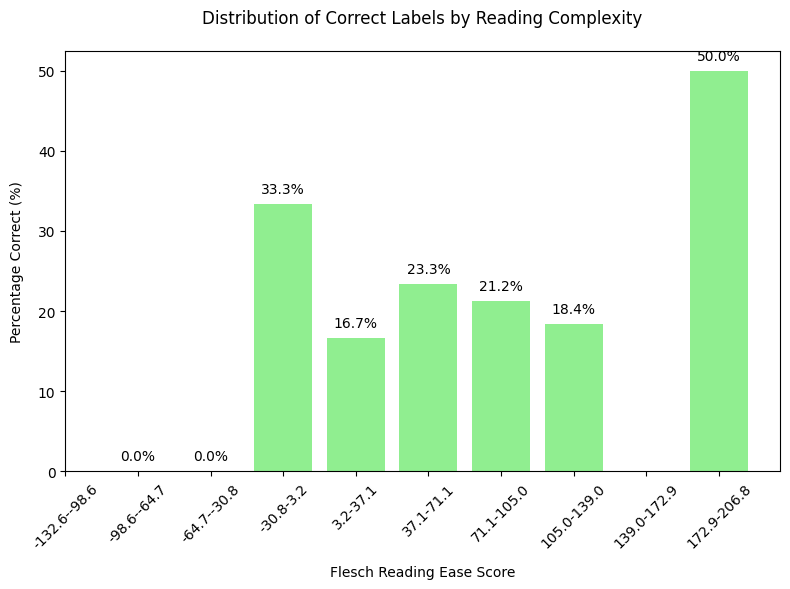

In [41]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))

# create bins
complexity_bins = np.linspace(train_set['Flesch_reading_ease'].min(),
                              train_set['Flesch_reading_ease'].max(),
                              11)

complexity_groups = train_set.groupby(pd.cut(train_set['Flesch_reading_ease'], bins=complexity_bins))
complexity_correct = complexity_groups.apply(lambda x: (x['GroundTruth'] == True).mean() * 100)

# create plot
bars = ax.bar(range(len(complexity_correct)), complexity_correct, color='lightgreen')
ax.set_title('Distribution of Correct Labels by Reading Complexity', pad=20)
ax.set_xlabel('Flesch Reading Ease Score', labelpad=10)
ax.set_ylabel('Percentage Correct (%)', labelpad=10)

# add labels
ax.set_xticks(range(len(complexity_correct)))
ax.set_xticklabels([f'{bin.left:.1f}-{bin.right:.1f}'
                    for bin in complexity_correct.index],
                   rotation=45)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2., height + 1,
            f'{height:.1f}%',
            ha='center', va='bottom')

plt.tight_layout()
plt.show()

/var/folders/p2/np2c5vd9481fwp0zsm_9m3h00000gn/T/ipykernel_84407/1159074665.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  length_groups = train_set.groupby(pd.cut(train_set['Answer.explanation_length'], bins=length_bins))


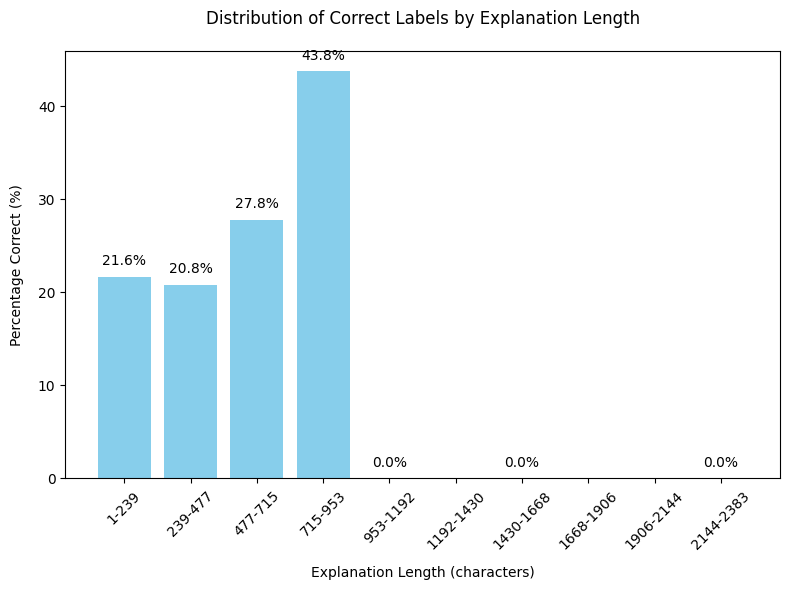

In [42]:
import numpy as np

fig, ax = plt.subplots(figsize=(8, 6))

# create bins
length_bins = np.linspace(train_set['Answer.explanation_length'].min(),
                          train_set['Answer.explanation_length'].max(),
                          11)

length_groups = train_set.groupby(pd.cut(train_set['Answer.explanation_length'], bins=length_bins))
length_correct = length_groups.apply(lambda x: (x['GroundTruth'] == True).mean() * 100)

# create plot
bars = ax.bar(range(len(length_correct)), length_correct, color='skyblue')
ax.set_title('Distribution of Correct Labels by Explanation Length', pad=20)
ax.set_xlabel('Explanation Length (characters)', labelpad=10)
ax.set_ylabel('Percentage Correct (%)', labelpad=10)

# add labels
ax.set_xticks(range(len(length_correct)))
ax.set_xticklabels([f'{int(bin.left)}-{int(bin.right)}'
                    for bin in length_correct.index],
                   rotation=45)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2., height + 1,
            f'{height:.1f}%',
            ha='center', va='bottom')

plt.tight_layout()
plt.show()

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

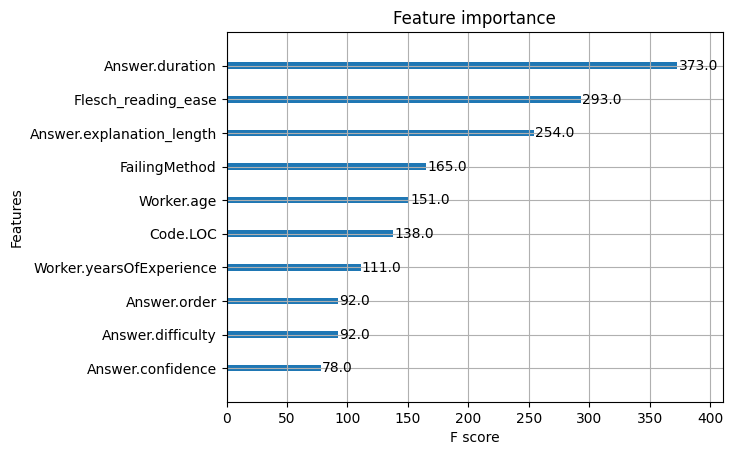

In [43]:
xgboost.plot_importance(xgb_model, importance_type='weight', max_num_features=10)